# Previsão de Engajamento - Regressão

In [1]:
#@title Importações de pacote
import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedKFold, LeavePOut
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [2]:
BASE_PATH = 'dados/'

In [3]:
#@title Definições Auxiliares
class Identity(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        return X

    def fit_transform(self, X, y=None):
        return X

def plot_actual_predicted_comparison(model, x, y, log=False):
    y_pred = model.predict(x)

    if log:
        y_pred = np.log(y_pred)
        y = np.log(y)

    # Plota scatter plot 
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(y, y_pred, alpha=0.5)
    ymin, ymax = min(y.min(), y_pred.min()), max(y.max(), y_pred.max())
    ax.plot([ymin, ymax], [ymin, ymax], 'r--', lw=2)
    ax.set_xlabel('Valor Real')
    ax.set_ylabel('Valor Previsto')
    ax.set_title(f'Gráfico de Dispersão: Valor Real vs Valor Previsto \nMelhor modelo: {model.__class__.__name__}')
    plt.show()

    # Plota gráfico de linhas
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.plot(y.index, y, alpha=0.7, label="Real")
    ax.plot(y.index, y_pred, alpha=0.7, label="Previsto")
    odd_years = y.index[(y.index % 2) == 1]
    ax.set_xticks(odd_years)
    plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
    #ax.set_xlabel('Ano')
    ax.set_ylabel('Total de chuva do período chuvoso (abr-jul)')
    ax.set_title(f'Valor Real vs Valor Previsto por Ano \nMelhor modelo: {model.__class__.__name__}')
    ax.legend()
    plt.show()


# 1 - Carrega os Dados

Carregando dados brutos.

In [4]:
dfx = pd.read_excel(BASE_PATH + 'bolsonaro-preproc2-inputs.xlsx', index_col='ID')
dfx.head()


,Duracao,Dispositivo Retórico_Call to Action,Dispositivo Retórico_Collective Appeal,Dispositivo Retórico_Commitment,Dispositivo Retórico_Endorsement,Dispositivo Retórico_Fact/Statistic,Dispositivo Retórico_Humor,Dispositivo Retórico_Nenhum,Dispositivo Retórico_Opinion,Dispositivo Retórico_Personal Appeal,...,Retórica Aristotélica_Pathos,Tipo de conteúdo_Nenhum,Tipo de conteúdo_Personal,Tipo de conteúdo_Political-Ideological,Tipo de conteúdo_Political-Purposeful,Tonalidade_Neutral,Tonalidade_Positive,Texto / Hashtag_Nenhum,Texto / Hashtag_Texto,Texto / Hashtag_Texto + Hashtag
ID,,,,,,,,,,,,,,,,,,,,,
7114971700365691904,57.93,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
7115050482179050496,17.13,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
7115120078982631424,52.54,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
7115161088219565056,34.48,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7115207919750253568,66.66,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [5]:
dfy = pd.read_excel(BASE_PATH + 'bolsonaro-preproc2-outputs.xlsx', index_col='ID')
dfy.head()

,Curtidas,Curtidas-Log,Curtidas-4Classes,Curtidas-2Classes
ID,,,,
7114971700365691904,24400,10.102338,medium-low,0
7115050482179050496,9163,9.122929,low,0
7115120078982631424,3485,8.156223,low,0
7115161088219565056,22100,10.003333,medium-low,0
7115207919750253568,115700,11.658756,high,1


In [6]:
dfy = dfy['Curtidas']
#dfy = dfy['Curtidas-Log']

# 2 - Seleção do Modelo com Grid Search

Dados que serão usados para a otimização de parâmetros com o *grid search*.

(No momento, estou usando *todos* os dados.)

In [7]:
dfx_grid = dfx
dfy_grid = dfy

## 2.1 - Treinamento simples, sem otimização

In [8]:
model = LinearRegression()
model.fit(dfx_grid, dfy_grid)

LinearRegression()

In [9]:
#mean_squared_error(dfy_test, model.predict(dfx_test))
mean_squared_error(dfy_grid, model.predict(dfx_grid))

19109516501.169098

C:\Users\pablo\AppData\Local\Temp\ipykernel_5020\2515103024.py:19: RuntimeWarning: invalid value encountered in log
  y_pred = np.log(y_pred)


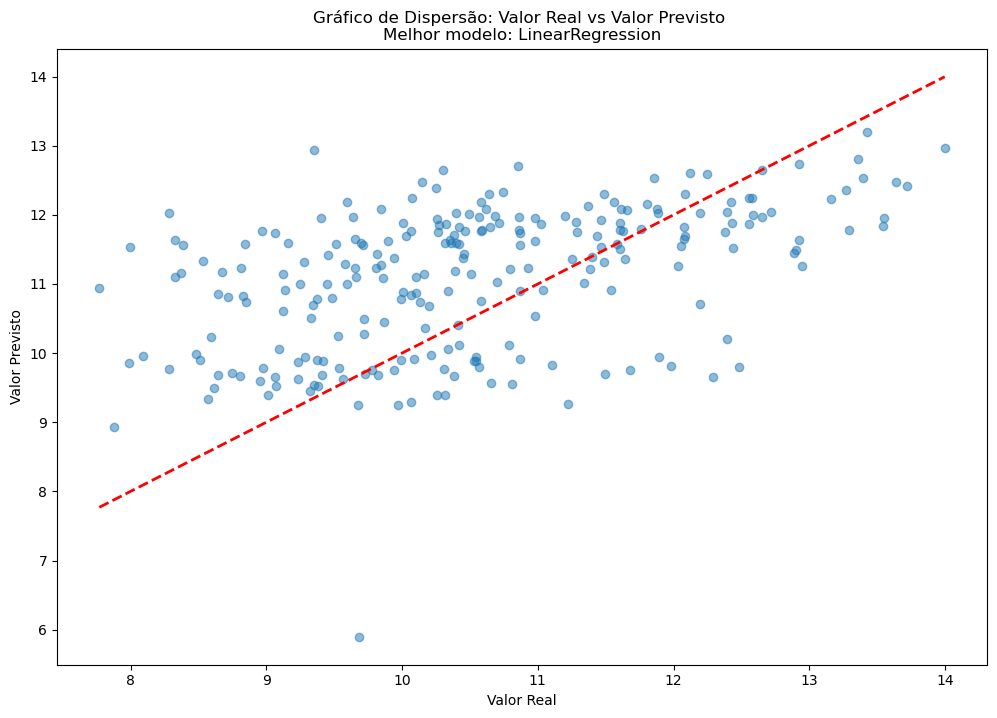

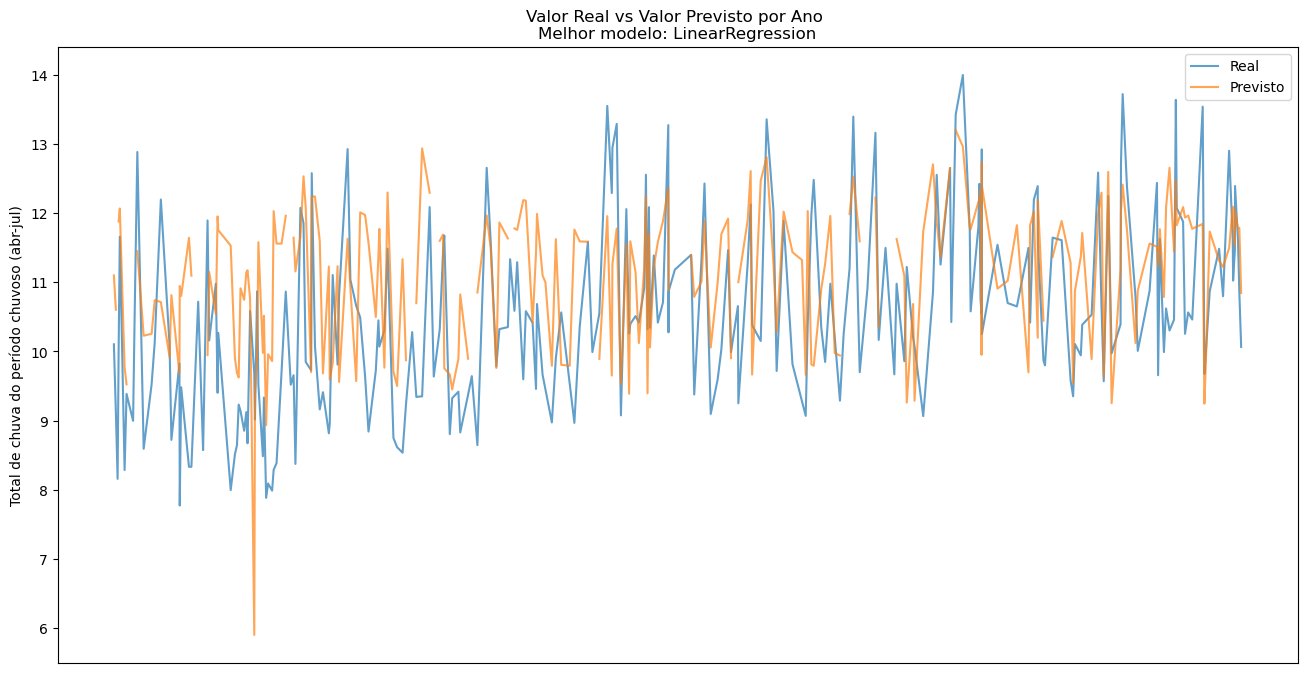

In [10]:
#plot_actual_predicted_comparison(model, dfx, dfy)
plot_actual_predicted_comparison(model, dfx, dfy, log=True)

## 2.2 - Grid Search com Vários Modelos

In [11]:
# Lista de modelos e hiperparâmetros para testar
# É uma lista de trios: nome do modelo, classe do modelo (às vezes, um pipeline incluindo um scaler) e dicionário de hiperparâmetros
models = [
  ('Decision Tree', 
    DecisionTreeRegressor(), 
    {'max_depth': [5, 15, 20], 'min_samples_split': [5, 10, 15], 'min_samples_leaf': [1, 2, 5], 'max_features': ['sqrt', 'log2']}),
  
  #('Support Vector Machine', SVR(), 
  #  {'C': [0.1, 200, 700, 1000], 'gamma': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}),
  
  ('KNN Regressor', 
    Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())]), 
   {'scaler': [Identity(), StandardScaler(with_mean=True), StandardScaler(with_mean=False), MinMaxScaler()], 
    'knn__n_neighbors': [3, 7, 15], 'knn__weights': ['uniform', 'distance'], 'knn__p': [1, 2]}),

  ('Random Forest', RandomForestRegressor(), 
    {'n_estimators': [5, 10, 20], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 5], 'max_features': ['sqrt', 'log2']}),
  #  {'n_estimators': [2] }), # para deixá-lo, porém com desempenho limitado

  #('Gradient Boosting', GradientBoostingRegressor(), 
  #  {'n_estimators': [20, 40, 60], 'max_depth': [2, 5, 10], 'learning_rate': [0.01, 0.1, 0.2, 0.3], 'loss': ['squared_error', 'absolute_error', 'huber']}),
  
  #('Linear Regression', Pipeline([('scaler', StandardScaler()), ('linreg', LinearRegression())]),
  #  {'scaler': [Identity(), StandardScaler(with_mean=True), StandardScaler(with_mean=False), MinMaxScaler()]}),

  #('Lasso Regressor', Pipeline([('scaler', StandardScaler()), ('lasso', Lasso())]),
  #  {'scaler': [Identity(), StandardScaler(with_mean=True), StandardScaler(with_mean=False), MinMaxScaler()], 
  #  'lasso__alpha': [0.1, 1, 10], 'lasso__fit_intercept': [True, False],
  #})
]

In [12]:
# Dicionário para armazenar os resultados dos modelos
results = {}
best_result = None

# Loop pelos diferentes modelos
for model_name, model, param_grid in models:
    time_start = time.time()
    # Cria o grid search com validação cruzada
    grid_search = GridSearchCV(model, param_grid, cv=RepeatedKFold(n_splits=10, n_repeats=3), scoring='neg_mean_squared_error')

    # Treina o modelo com grid search e cross validation
    grid_search.fit(dfx_grid, dfy_grid)
    gridsearch_score = -grid_search.best_score_

    results[model_name] = (grid_search.best_estimator_, grid_search.best_params_, gridsearch_score)
    time_end = time.time()

    # Imprime o nome do modelo, nome do conjunto de features, melhores hiperparâmetros e pontuação no conjunto de validação
    print(f'Model: {model_name}, Best params: {grid_search.best_params_}, GridSearch best score: {gridsearch_score:.2f}, Elapsed time: {(time_end - time_start):.1f} secs')

    if best_result is None or gridsearch_score < best_result:
        best_result = gridsearch_score
        best_result_key = model_name


Model: Decision Tree, Best params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5}, GridSearch best score: 26262994814.97, Elapsed time: 6.5 secs
Model: KNN Regressor, Best params: {'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform', 'scaler': MinMaxScaler()}, GridSearch best score: 24943353736.28, Elapsed time: 45.5 secs
Model: Random Forest, Best params: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 20}, GridSearch best score: 25134616849.52, Elapsed time: 104.2 secs


In [13]:
best_model_grid, best_params_grid, best_grid_score = results[best_result_key]
print()
print(f'BEST RESULTS:')
print(f'-> model: {best_result_key}')
print(f'-> params: {best_params_grid}')
print(f'-> grid-search score: {best_grid_score:.2f}')
print()
assert best_grid_score == best_result


BEST RESULTS:
-> model: KNN Regressor
-> params: {'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform', 'scaler': MinMaxScaler()}
-> grid-search score: 24943353736.28



# 3 - Estimando os Atributos Mais Importantes


- Atributos mais altos na árvore
- Atributos mais usados nos nós da árvore
- Valor de 'feature_importances_' calculado no modelo

In [14]:
#@title Definições auxiliares (não precisa abrir)
from sklearn.tree import plot_tree
import numpy as np
import matplotlib.pyplot as plt

def plot_importance(model, max_features=None, feature_names=None, sort=True, ax=None):
    """
    Plot feature importances for a scikit-learn random forest or gradient boosting model.

    Parameters
    ----------
    model : object
        A scikit-learn random forest or gradient boosting model.
    max_features : int or None, optional (default=None)
        The maximum number of features to plot. If None, plot all features.
    feature_names : list or None, optional (default=None)
        A list of feature names to use in the plot. If None, use the feature indices.
    sort : bool, optional (default=True)
        Whether to sort the feature importances in descending order.
    ax : matplotlib.axes.Axes or None, optional (default=None)
        The matplotlib axes to plot the feature importances on. If None, create a new figure and axes.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The matplotlib axes containing the plot.

    """
    # Extract feature importances
    importances = model.feature_importances_

    # Get feature names
    if feature_names is None:
        feature_names = [str(i) for i in range(len(importances))]

    # Sort feature importances
    if sort:
        indices = np.argsort(importances)[::-1]
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]

    # Truncate feature importances
    if max_features is not None:
        importances = importances[:max_features]
        feature_names = feature_names[:max_features]

    # Create plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.barh(np.arange(len(importances)), importances, align='center')
    ax.set_yticks(np.arange(len(importances)))
    ax.set_yticklabels(feature_names)
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()

    return ax


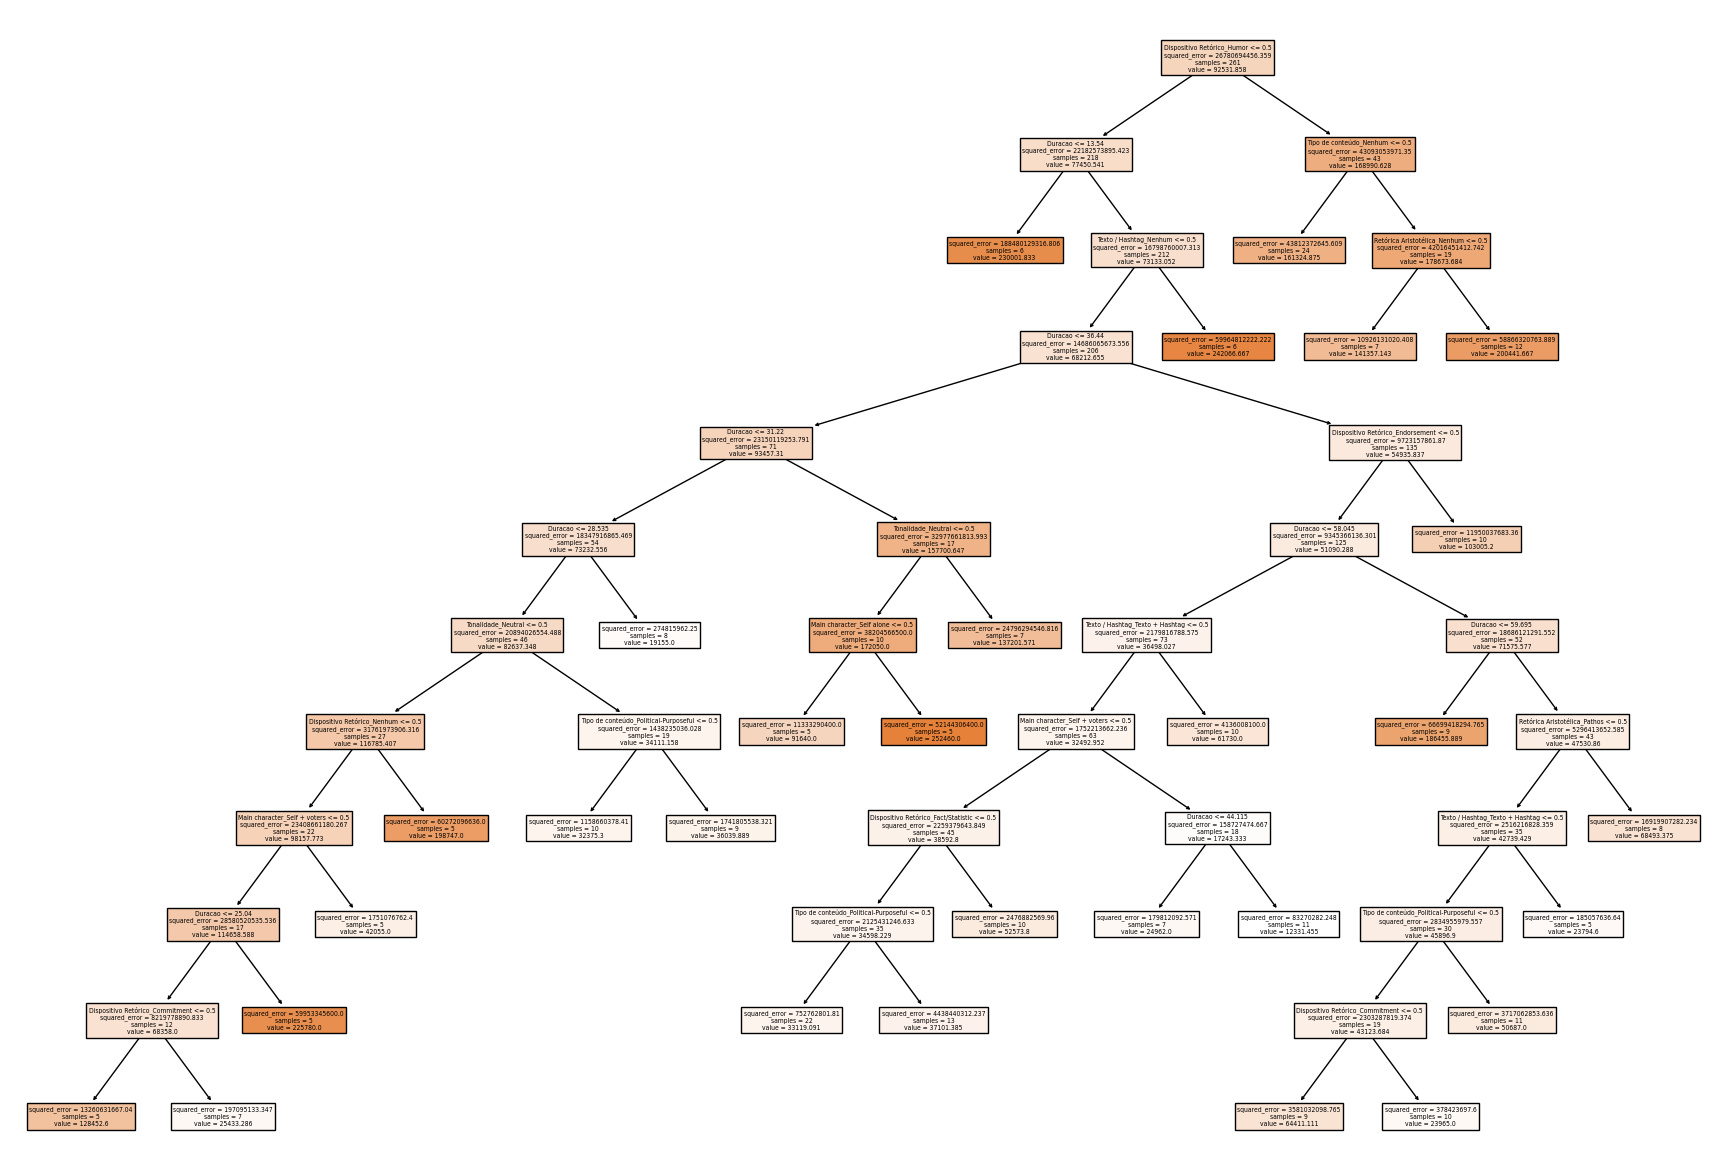

In [16]:
dec_tree = results['Decision Tree'][0]
fig = plt.figure(figsize=(22,15))
plot_tree(dec_tree, feature_names=list(dfx_grid.columns), filled=True);

In [17]:
rf = results['Random Forest'][0]
#pd.DataFrame({'features' : df_x.columns[2:], 'feature_importance' : rf.feature_importances_}).sort_values(by='feature_importance', ascending=False)

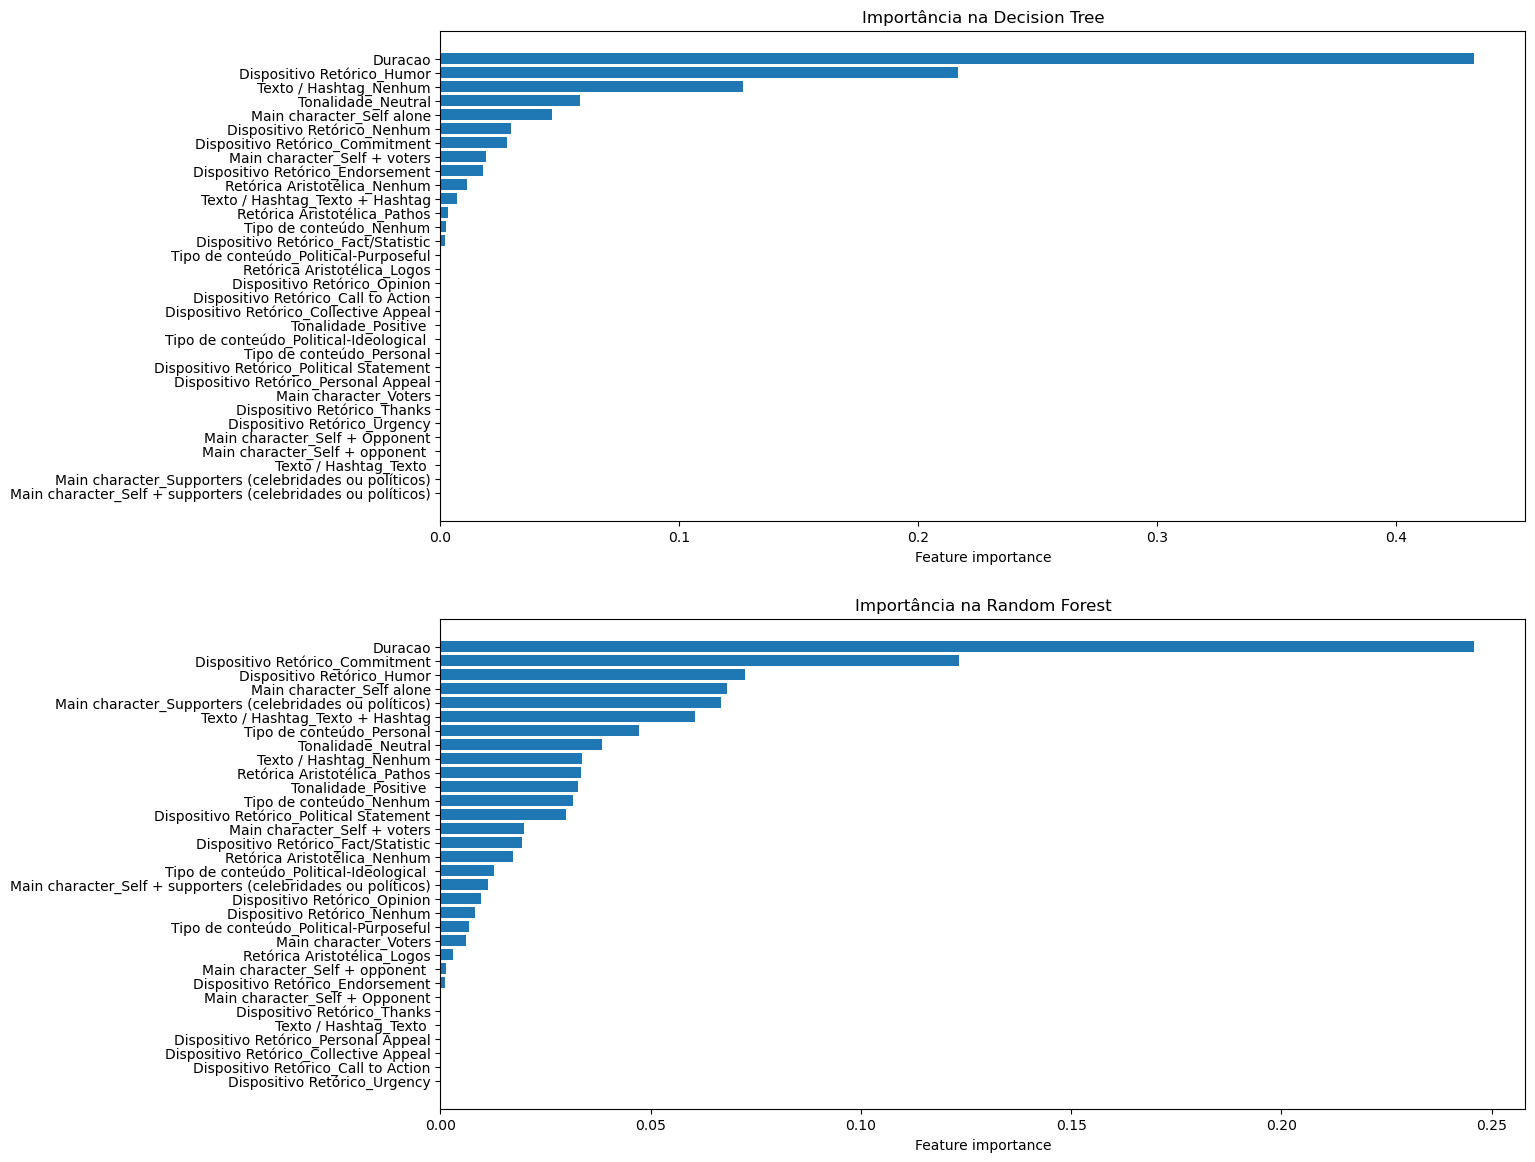

In [18]:
# plot the feature importances
fig, ax = plt.subplots(2, 1, figsize=(14, 14))
ax[0].set_title('Importância na Decision Tree')
plot_importance(dec_tree, feature_names=dfx_grid.columns, ax=ax[0])
ax[1].set_title('Importância na Random Forest')
plot_importance(rf, feature_names=dfx_grid.columns, ax=ax[1])
plt.show()

# 4 [pular esta seção] - Otimização Refinada do Melhor com o Optuna

Gabrielly, esta seção não está sendo usada!

In [19]:
#@title Definições Auxiliares
scaler_names = ['ident', 'std', 'std_nomean', 'minmax']
scaler_obj = {'ident' : Identity(), 'std': StandardScaler(with_mean=True), 'std_nomean': StandardScaler(with_mean=False), 'minmax': MinMaxScaler()}

CV_OPTION = LeavePOut(p=2)  # alt. mais simples: CV_OPTION=7

def objective_knn(trial):
    # Define the hyperparameters to be optimized
    scaler = trial.suggest_categorical('scaler', scaler_names)
    n_neighbors = trial.suggest_int("knn__n_neighbors", 1, 9)
    weights = trial.suggest_categorical("knn__weights", ['uniform', 'distance'])
    p = trial.suggest_int("knn__p", 1, 2)

    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p)
    model = Pipeline([('scaler', scaler_obj[scaler]), ('knn', knn)])

    # Evaluate with cross-validation
    return -cross_val_score(model, dfx_grid, dfy_grid, cv=CV_OPTION, scoring='neg_mean_squared_error').mean()

def objective_decisiontree(trial):
    # Define the hyperparameters to be optimized
    max_depth = trial.suggest_int("max_depth", 5, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 12)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # Create the model
    model = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )

    # Evaluate with cross-validation
    return -cross_val_score(model, dfx_grid, dfy_grid, cv=CV_OPTION, scoring='neg_mean_squared_error').mean()

def objective_randomforest(trial):
    # Define the hyperparameters to be optimized
    n_estimators = trial.suggest_int("n_estimators", 5, 20)
    max_depth = trial.suggest_int("max_depth", 5, 15)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2"])

    # Create a RandomForestRegressor model
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    )

    # Evaluate with cross-validation
    return -cross_val_score(model, dfx_grid, dfy_grid, cv=CV_OPTION, scoring='neg_mean_squared_error').mean()

In [20]:
import optuna

ModuleNotFoundError: No module named 'optuna'

In [ ]:
if best_result_key == 'KNN Regressor':
  objective = objective_knn
elif best_result_key == 'Decision Tree':
  objective = objective_decisiontree
else:
  objective = objective_randomforest

# Define the Optuna study and run the optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=150)

output.clear()

NameError: name 'optuna' is not defined

In [ ]:
best_params_opt = study.best_params

if best_result_key == 'KNN Regressor':
  best_params_opt['scaler'] = scaler_obj[ best_params_opt['scaler'] ]

print('Melhores parâmetros com o Optuna:')
print(f'- {best_params_opt}')
print(f'- score: {study.best_value:.2f}')

Melhores parâmetros com o Optuna:
- {'scaler': StandardScaler(with_mean=False), 'knn__n_neighbors': 3, 'knn__weights': 'distance', 'knn__p': 1}
- score: 47255.02


In [ ]:
best_params_grid

{'knn__n_neighbors': 3,
 'knn__p': 1,
 'knn__weights': 'distance',
 'scaler': MinMaxScaler()}

In [ ]:
best_model_opt = clone(best_model_grid)
best_model_opt.set_params(**best_params_opt)
best_model_opt

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('knn',
                 KNeighborsRegressor(n_neighbors=3, p=1, weights='distance'))])

## Seleciona melhor versão após vários reinicios

In [ ]:
# Acho que causa overfit !!
best_score = None
best_model_opt_refit = None

model = clone(best_model_opt) # clone o modelo que já tem os parâmetros obtidos com o optuna
params = model.get_params()   # pega todos os parâmetros do modelo (mesmo os que o optuna não ajustou)

random_trials = 100 if ('random_state' in params) else 1

for trial in range(random_trials):
  if random_trials > 1:
    params['random_state'] = trial+7

  model.set_params(**params)
  model.fit(dfx_grid, dfy_grid)
  
  y_pred = model.predict(dfx_grid)

  r2   = r2_score(dfy_grid, y_pred)
  mse  = mean_squared_error(dfy_grid, y_pred)
  mape = mean_absolute_percentage_error(dfy_grid, y_pred)
  print(f"- Metrics: r2={r2:.3f} / MSE={mse:.3f} / MAPE={mape:.3f}")

  if (trial % 10) == 0:
    output.clear()
  
  if best_score is None or r2 > best_score:
    best_score = r2
    best_model_opt_refit = model  # mantém o modelo treinando
    model = clone(model)         # cria uma cópia para retreinar com os mesmos parâmetros (mas variando o random_state)
  
best_model_opt_refit

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('knn',
                 KNeighborsRegressor(n_neighbors=3, p=1, weights='distance'))])

# 5 - Treinamento e Avaliação do Modelo Final

Recomendações para decidir quantos dados usar para treinar o modelo final:

1. É importante considerar o **equilíbrio entre *bias* e variância**. 
  - usar todos os dados disponíveis para treinar o modelo pode aumentar o **bias** (viés) do modelo;
  - usar apenas parte dos dados pode aumentar a **variância** do modelo. 

2. Em geral, é recomendável usar a **maior quantidade** de dados possível para treinar o modelo final, desde que isso não comprometa a capacidade do modelo de generalizar para novos dados. 

3. Pode ser útil usar a validação cruzada para avaliar o desempenho do modelo com diferentes quantidades de dados e escolher o modelo que tenha o melhor equilíbrio entre bias e variância. (Estamos fazendo isso na escolha do melhor modelo, antes).

In [21]:
# divide os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(dfx, dfy, test_size=0.2, random_state=42)

In [22]:
best_model_grid.fit(X_train, y_train)
y_pred = best_model_grid.predict(X_test)

In [23]:
r2   = r2_score(y_test, y_pred)
mse  = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

best_model = best_model_grid
best_r2 = r2

print(f"- Metrics for grid-search-optimized model: r2={r2:.3f} / MSE={mse:.3f} / MAPE={mape:.3f}")

- Metrics for grid-search-optimized model: r2=0.103 / MSE=29871706593.469 / MAPE=2.005


In [24]:
'''best_model_opt.fit(X_train, y_train)
y_pred = best_model_opt.predict(X_test)'''

'best_model_opt.fit(X_train, y_train)\ny_pred = best_model_opt.predict(X_test)'

In [25]:
'''r2   = r2_score(dfy_test, y_pred)
mse  = mean_squared_error(dfy_test, y_pred)
mape = mean_absolute_percentage_error(dfy_test, y_pred)

if r2 < best_r2:
  best_model = best_model_opt
  best_r2 = r2  

print(f"- Metrics for optuna-optimized model: r2={r2:.3f} / MSE={mse:.3f} / MAPE={mape:.3f}")'''

'r2   = r2_score(dfy_test, y_pred)\nmse  = mean_squared_error(dfy_test, y_pred)\nmape = mean_absolute_percentage_error(dfy_test, y_pred)\n\nif r2 < best_r2:\n  best_model = best_model_opt\n  best_r2 = r2  \n\nprint(f"- Metrics for optuna-optimized model: r2={r2:.3f} / MSE={mse:.3f} / MAPE={mape:.3f}")'

In [26]:
'''# já foi treinado!
y_pred = best_model_opt_refit.predict(dfx_test)

r2   = r2_score(dfy_test, y_pred)
mse  = mean_squared_error(dfy_test, y_pred)
mape = mean_absolute_percentage_error(dfy_test, y_pred)

if r2 < best_r2:
  best_model = best_model_opt_refit
  best_r2 = r2  

print(f"- Metrics for optuna-optimized with multiple refits model: r2={r2:.3f} / MSE={mse:.3f} / MAPE={mape:.3f}")'''

'# já foi treinado!\ny_pred = best_model_opt_refit.predict(dfx_test)\n\nr2   = r2_score(dfy_test, y_pred)\nmse  = mean_squared_error(dfy_test, y_pred)\nmape = mean_absolute_percentage_error(dfy_test, y_pred)\n\nif r2 < best_r2:\n  best_model = best_model_opt_refit\n  best_r2 = r2  \n\nprint(f"- Metrics for optuna-optimized with multiple refits model: r2={r2:.3f} / MSE={mse:.3f} / MAPE={mape:.3f}")'

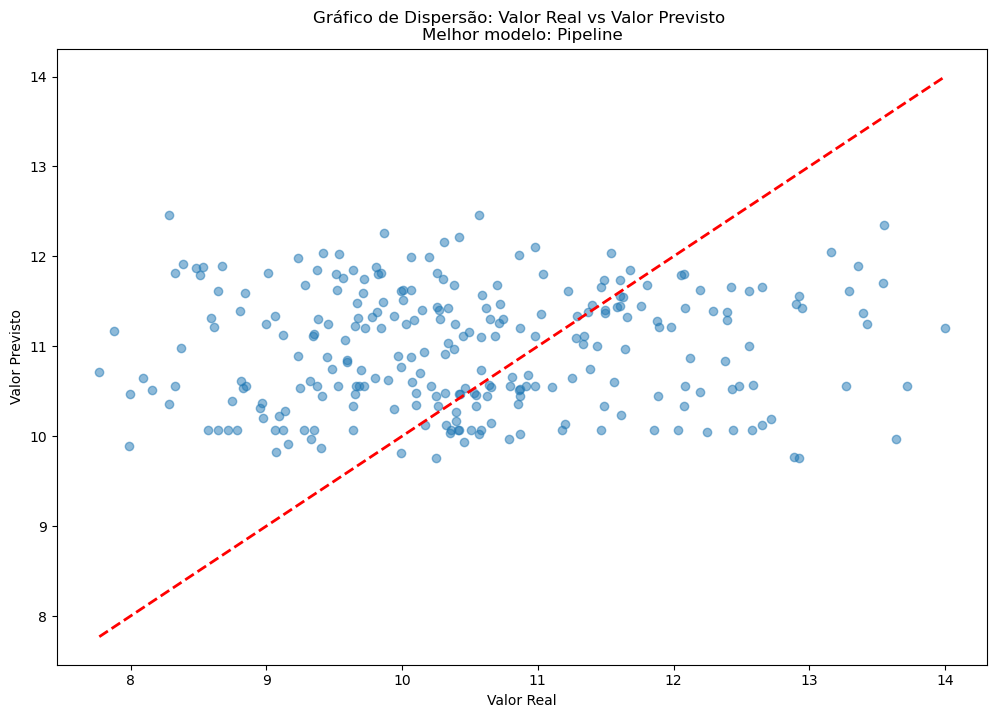

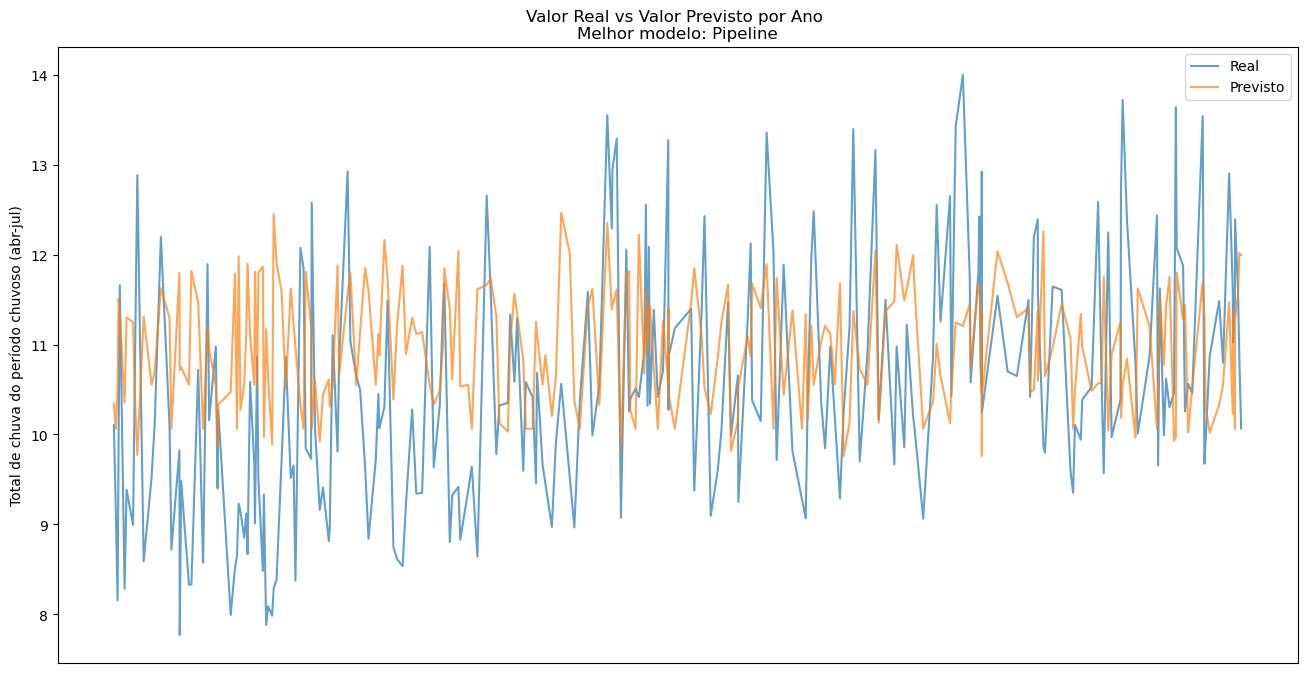

In [27]:
#plot_actual_predicted_comparison(best_model, dfx[selected_features], dfy)
plot_actual_predicted_comparison(best_model, pd.concat([X_train, X_test]), dfy, log=True) 